### API

- https://open.gsa.gov/api/regulationsgov/

In [1]:
import glob
import os
import json
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# set the max columns to none
pd.set_option('display.max_columns', None)

### Data Extraction

##### Data Components:

- Proposed Regulation Document: The official text outlining the new regulation.
- Public Comments: Feedback from individuals, organizations, and businesses regarding the regulation.


##### Tools & Libraries:

- Web Scraping: Use libraries like BeautifulSoup, Scrapy, or Selenium to extract data.
- APIs: https://open.gsa.gov/api/regulationsgov/
- Manual Download: For smaller datasets, manually download and process the data.

##### Data Storage:

- Store the extracted data in structured formats like CSV, JSON, or databases (e.g., SQLite, PostgreSQL).

### Load or Download all Dockets

- Load `1_federa_regulation_all_dockets.json` file from folder
- if above file is not available, then do following steps
  - Search term `Federal Regulations` and get all the dockets
  - Save all the dockets in file name `1_federa_regulation_all_dockets.json`

In [ ]:
# create folder for storing federation regulation data

if os.path.exists("dockets_documents") is False:
    print("folder not found")
    os.mkdir("dockets_documents")
    print("folder created!!")
else:
    print("Folder is already there")

folder not found
folder created!!


In [ ]:
path = "1_federa_regulation_all_dockets.json"

if os.path.exists(path):
    with open(path, 'r') as f:
        all_dockets = json.load(f)
    print("Dockets List loaded from file")
else:
    print("Dockets List not found, will be download from regulations.gov/v4")
    all_dockets = {}
    for N in range(1, 21):
        only_dockets = f"https://api.regulations.gov/v4/dockets?filter[searchTerm]=federal%20regulations&page[Number]={N}&page[Size]=250&api_key=4gcihMmDHcdkqhIbbORQlers3Hcx8gql9lmOzkKv"
        response = requests.get(only_dockets)
        only_dockets = response.text
        only_dockets = json.loads(only_dockets)

        next_page = only_dockets['meta']['lastPage']

        all_dockets.update({"Page_"+str(N) : only_dockets})
        time.sleep(10)

    with open(path, 'w') as f:
        json.dump(all_dockets, f)

total_dockets = 0
for i in all_dockets.keys():
    for do in all_dockets[i]['data']:
        dkt_id = do['id']
        total_dockets += 1

print("Total Dockets", total_dockets)

Dockets List loaded from file
Total Dockets 3859


In [ ]:
all_dockets.keys()

dict_keys(['Page_1', 'Page_2', 'Page_3', 'Page_4', 'Page_5', 'Page_6', 'Page_7', 'Page_8', 'Page_9', 'Page_10', 'Page_11', 'Page_12', 'Page_13', 'Page_14', 'Page_15', 'Page_16', 'Page_17', 'Page_18', 'Page_19', 'Page_20'])

### Download Documents Related to Docket

- For each Docket using ID, see if ID.json file does not exist in `dockets_documents`, do following
  - Get all the documents related to that docket ID
  - Save ID.json file to folder 'docket_documents.json'

In [ ]:
dockets_documents = "dockets_documents/"

In [ ]:
all_documents_of_dockets = {}
for i in all_dockets.keys():
    for do in all_dockets[i]['data']:

        dkt_id = do['id']

        available_dockets = glob.glob(dockets_documents+"/*")

        if dockets_documents+dkt_id+".json" in available_dockets:
            print(dkt_id, " Docket already downloaded")
            continue

        doket_pages = {}
        for N in range(1, 21):
            all_documents = f"https://api.regulations.gov/v4/documents?filter[docketId]={dkt_id}&page[Number]={N}&page[Size]=250&api_key=4gcihMmDHcdkqhIbbORQlers3Hcx8gql9lmOzkKv"
            response = requests.get(all_documents)
            all_documents = response.text
            all_documents = json.loads(all_documents)
            doket_pages.update({"Page_"+str(N) : all_documents})
            time.sleep(3)

            try:
                next_page = all_documents['meta']['lastPage']
            except:
                continue

            if next_page == True:
                print("Last page")
                break

        path = dockets_documents + dkt_id + ".json"

        with open(path, 'w+') as f:
            json.dump(doket_pages, f)

        print(dkt_id, " Docket downloaded!!!")

### Extract Comments on Each Document

In [ ]:
def extract_comments_document(docket_doc):

    comments_list = {}

    for page_no in docket_doc.keys():

        meta = docket_doc[page_no]['meta']['totalElements']

        for doc in docket_doc[page_no]['data']:

            obj_id = doc['attributes']['objectId']

            for N in range(1, 21):

                all_comments_on_document = f"https://api.regulations.gov/v4/comments?filter[commentOnId]={obj_id}&page[Number]={N}&page[Size]=250&api_key=4gcihMmDHcdkqhIbbORQlers3Hcx8gql9lmOzkKv"

                response = requests.get(all_comments_on_document)

                all_comments_on_document = response.text

                all_comments_on_document = json.loads(all_comments_on_document)

                try:
                    next_page = all_comments_on_document['meta']['lastPage']
                except:
                    continue

                if page_no not in comments_list.keys():
                    comments_list.update({page_no : {}})

                if obj_id not in comments_list[page_no].keys():
                    comments_list[page_no].update({obj_id : []})

                comments_list[page_no][obj_id].append(all_comments_on_document)

                time.sleep(2)

                if next_page == True:
                    print("Last page")
                    break

    return comments_list

In [ ]:
# create folder for storing federation regulation comments data

if os.path.exists("document_comments") is False:
    print("folder not found")
    os.mkdir("document_comments")
    print("folder created!!")
else:
    print("Folder is already there")

folder not found
folder created!!


In [ ]:
comments_path = "document_comments"

available_dockets = glob.glob(dockets_documents+"/*")

available_comments = glob.glob(comments_path+"/*")

available_comments = [i.split("/")[-1].split("\\")[-1] for i in available_comments]

for file in available_dockets:


    if file.split("documents")[-1][1:] in available_comments:
        print(file.split("documents")[-1][1:], " comments already downloaded")
        continue

    with open(file, 'r') as f:

        docket_doc = json.load(f)

    comments_json = extract_comments_document(docket_doc)

    with open(comments_path+"/"+file.split("documents")[-1][1:], 'w+') as f:

        json.dump(comments_json, f)

In [ ]:
# create folder for storing federation regulation final comments data

if os.path.exists("final_comments") is False:
    print("folder not found")
    os.mkdir("final_comments")
    print("folder created!!")
else:
    print("Folder is already there")

folder not found
folder created!!


In [ ]:
all_comments = {}

final_comments = "final_comments"

available_final_comments = glob.glob(final_comments+"/*")

available_final_comments = [i.split("/")[-1].split("\\")[-1] for i in available_final_comments]

for com in glob.glob(comments_path+"/*"):

        if com.split("/")[-1].split("\\")[-1] in available_final_comments:
            print(com.split("/")[-1].split("\\")[-1], " comments already downloaded")
            continue

        with open(com, 'r') as f:
            doc = json.load(f)

        for page in doc.keys():
            for obj in doc[page].keys():
                for objet in doc[page][obj]:
                    if objet['data'] != []:
                        this_var = objet
                        if this_var['data'] != []:
                            for comment in this_var['data']:

                                comment_id = comment['id']
                                all_comments_on_document = f"https://api.regulations.gov/v4/comments/{comment_id}?api_key=4gcihMmDHcdkqhIbbORQlers3Hcx8gql9lmOzkKv"
                                response = requests.get(all_comments_on_document)
                                response = json.loads(response.text)

                                if com.split("/")[-1].split("\\")[-1] not in all_comments.keys():
                                    all_comments.update({com.split("/")[-1] : []})

                                all_comments[com.split("/")[-1].split("\\")[-1]].append(response)
                                time.sleep(2)

        if all_comments != {}:
            with open(final_comments+"/"+com.split("/")[-1].split("\\")[-1], 'w+') as f:
                json.dump(all_comments, f)

In [ ]:
final_comments = "final_comments"

len(glob.glob(final_comments+"/*"))

0

### For each JSON document Create Final Dataset

In [ ]:
final_df_for_analysis = None

In [ ]:
for file in glob.glob(final_comments+"/*"):

    with open(file, 'r') as f:
        data = json.load(f)

    print(file)

    for doc in data.keys():

        data_list = data[doc]

        for dataset in data_list:


            if 'data' not in list(dataset.keys()):
                continue

            dataset = dataset['data']

            dataset = pd.json_normalize(
              dataset,
              sep='_',  # Use underscore to join nested keys for easier readability
              errors='ignore'  # Skip entries that cause issues instead of failing
            )

            if final_df_for_analysis is None:
                final_df_for_analysis = dataset
            else:
                final_df_for_analysis = pd.concat([final_df_for_analysis, dataset])

In [ ]:
if final_df_for_analysis is None:
    final_df_for_analysis = pd.read_csv("final_df_for_analysis.csv")

final_df_for_analysis.shape

(9922, 51)

### Cleaning of dataset

In [ ]:
remove = ["See attached file(s)", "Submission of public comment.", "See Attached",
          "See attached file.", "Public Comment Submission", "Comments attached<br/>",
         "Please see the attached letter comments.", "Please see attached comments of the Environmental Investigation Agency.",
         "RESPONSE TO PROPOSED RULE CHANGES IN 49 CFR Part 241", "FAC 2005-13, FAR Case 2005-13<br/>", "Public Submission Comments",
         "Submission for Public Comment", "Public Submission Comment", "See attached updated remarks",
         "Submission of public comment", "Public submission of comment", "This is a test submittal for the agency.<br/>"]

final_df_for_analysis = final_df_for_analysis[~final_df_for_analysis['attributes_comment'].isin(remove)]

final_df_for_analysis = final_df_for_analysis[~final_df_for_analysis['attributes_comment'].isna()]

final_df_for_analysis = final_df_for_analysis[~final_df_for_analysis['attributes_comment'].str.lower().str.contains("attached")]

final_df_for_analysis.shape

(3091, 51)

In [ ]:
final_df_for_analysis.head()

,id,type,links_self,attributes_commentOn,attributes_commentOnDocumentId,attributes_duplicateComments,attributes_address1,attributes_address2,attributes_agencyId,attributes_city,attributes_category,attributes_comment,attributes_country,attributes_displayProperties,attributes_docAbstract,attributes_docketId,attributes_documentType,attributes_email,attributes_fax,attributes_field1,attributes_field2,attributes_fileFormats,attributes_firstName,attributes_govAgency,attributes_govAgencyType,attributes_objectId,attributes_lastName,attributes_legacyId,attributes_modifyDate,attributes_organization,attributes_originalDocumentId,attributes_pageCount,attributes_phone,attributes_postedDate,attributes_postmarkDate,attributes_reasonWithdrawn,attributes_receiveDate,attributes_restrictReason,attributes_restrictReasonType,attributes_stateProvinceRegion,attributes_submitterRep,attributes_submitterRepAddress,attributes_submitterRepCityState,attributes_subtype,attributes_title,attributes_trackingNbr,attributes_withdrawn,attributes_zip,attributes_openForComment,relationships_attachments_links_self,relationships_attachments_links_related
6,FAR-2013-0081-0012,comments,https://api.regulations.gov/v4/comments/FAR-20...,09000064811f4e73,FAR-2013-0081-0001,0,"1850 M St, NW",Suite 1000,FAR,Washington,NaN,"On behalf of Terry Brady, Senior VP, Chief Leg...",United States,"[{'name': 'pageCount', 'label': 'Page Count', ...",NaN,FAR-2013-0081,Public Submission,julia.farber@ul.com,NaN,NaN,NaN,NaN,Julia,NaN,NaN,09000064812264c3,Farber,NaN,2013-03-18T20:55:31Z,"UL, Inc.",NaN,0,202-530-6162,2013-03-18T04:00:00Z,NaN,NaN,2013-03-12T19:56:22Z,NaN,NaN,DC,NaN,NaN,NaN,Comment(s),Comment on FR Doc # 2013-03142,1jx-845v-ndkl,False,20036,False,https://api.regulations.gov/v4/comments/FAR-20...,https://api.regulations.gov/v4/comments/FAR-20...
11,FAR-2013-0081-0006,comments,https://api.regulations.gov/v4/comments/FAR-20...,09000064811f4e73,FAR-2013-0081-0001,0,409 D Street NE,NaN,FAR,Washington,NaN,"March 11, 2012<br/>Good morning and thank you ...",United States,"[{'name': 'pageCount', 'label': 'Page Count', ...",NaN,FAR-2013-0081,Public Submission,maclark@gwu.edu,NaN,NaN,NaN,NaN,Michele,NaN,NaN,09000064812241b3,Clark,NaN,2013-03-18T20:55:28Z,George Washington University,NaN,0,2022769027,2013-03-18T04:00:00Z,NaN,NaN,2013-03-11T16:38:47Z,NaN,NaN,DC,NaN,NaN,NaN,Comment(s),Comment on FR Doc # 2013-03142,1jx-8454-1asl,False,20002,False,https://api.regulations.gov/v4/comments/FAR-20...,https://api.regulations.gov/v4/comments/FAR-20...
17,FAR-2013-0081-0011,comments,https://api.regulations.gov/v4/comments/FAR-20...,09000064811f4e73,FAR-2013-0081-0001,0,"1700 Pennsylvania Ave. NW, Suite 520",NaN,FAR,Washington,NaN,The following submission and associated files ...,United States,"[{'name': 'pageCount', 'label': 'Page Count', ...",NaN,FAR-2013-0081,Public Submission,mowen@humanityunited.org,NaN,NaN,NaN,NaN,Meredith,NaN,NaN,090000648122649c,Owen,NaN,2013-03-18T20:55:30Z,Humanity United,NaN,0,202-503-3200,2013-03-18T04:00:00Z,NaN,NaN,2013-03-12T19:47:41Z,NaN,NaN,DC,NaN,NaN,NaN,Comment(s),Comment on FR Doc # 2013-03142,1jx-845v-5ij2,False,20006,False,https://api.regulations.gov/v4/comments/FAR-20...,https://api.regulations.gov/v4/comments/FAR-20...
18,FAR-2013-0081-0003,comments,https://api.regulations.gov/v4/comments/FAR-20...,09000064811f4e73,FAR-2013-0081-0001,0,"3 Patriot Lane, #13",NaN,FAR,Georgetown,NaN,The Humanitarian Alliance is an anti-trafficki...,United States,"[{'name': 'pageCount', 'label': 'Page Count', ...",NaN,FAR-2013-0081,Public Submission,cailink7@gmail.com,NaN,NaN,NaN,NaN,Cailin,PHS,Federal,0900006481207a29,James,NaN,2013-03-07T15:02:57Z,Humanitarian Alliance,NaN,0,9788107317,2013-03-07T05:00:00Z,NaN,NaN,2013-02-25T19:11:01Z,NaN,NaN,MA,Cailin James,NaN,NaN,Comment(s),Comment on FR Doc # 2013-03142,1jx-83vv-rkq7,False,01833,False,https://api.regulations.gov/v4/comments/FAR-20...,https://api.regulations.gov/v4/comments/FAR-20...
27,FAR-2013-0081-0035,comments,https://a

### You can also get data manally for the website using Bulk Download

![image.png](attachment:image.png)

https://www.regulations.gov/bulkdownload

![image.png](attachment:image.png)

In [ ]:
manual_data_aviation = pd.read_csv("manual_data/Federal Aviation.csv")
manual_data_regulation = pd.read_csv("manual_data/Federal Regulations.csv")

In [4]:
manual_data_aviation.shape

(12148, 60)

In [5]:
manual_data_aviation.head()

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
0,FAA-1997-3045-1040,FAA,FAA-1997-3045,loo-yq05-541b,Public Submission,2023-11-08T05:00Z,False,NaN,NaN,Comment from Anonymous,NaN,NaN,False,FAA-1997-3045-0001,NaN,NaN,NaN,2023-11-07T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anonymous,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I am writing you today to express my strong op...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FAA-2000-7980-0045,FAA,FAA-2000-7980,ly5-zov7-m224,Other,2024-07-03T04:00Z,False,NaN,NaN,Exemption/Rulemaking - Air Transport Associati...,2024-07-03T04:00Z,NaN,True,NaN,NaN,NaN,NaN,2024-07-03T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Request for Extension,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Airlines for America,NaN,NaN,NaN,NaN,NaN,"Petition for Renewal of Exemption No. 5533P, D...",NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2000-798...,NaN
2,FAA-2000-7980-0046,FAA,FAA-2000-7980,m01-05rp-72yb,Other,2024-08-19T04:00Z,False,NaN,NaN,U.S. DOT/FAA - Decision,2024-08-19T04:00Z,NaN,True,NaN,NaN,NaN,NaN,2024-08-19T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FAA,Federal,See attached file(s),NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2000-798...,NaN
3,FAA-2000-7980-0047,FAA,FAA-2000-7980,m02-eu2e-uil5,Other,2024-08-20T04:00Z,False,NaN,NaN,"Atlas Air, Inc. - Letter of Intent",2024-08-20T04:00Z,NaN,True,NaN,NaN,NaN,NaN,2024-08-20T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Atlas Air, Inc.",NaN,NaN,NaN,NaN,NaN,"See attached Atlas Air, Inc. Exemption 5533Q L...",NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2000-798...,NaN
4,FAA-2000-7980-0048,FAA,FAA-2000-7980,m0b-0ul7-y4s3,Other,2024-08-26T04:00Z,False,NaN,NaN,American Airlines Flight Operations - Letter o...,2024-08-26T04:00Z,NaN,True,NaN,NaN,NaN,NaN,2024-08-26T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Flight Operations,NaN,NaN,NaN,NaN,NaN,"American Airlines, Inc. - Letter of Intent",NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2000-798...,NaN


In [6]:
manual_data_regulation.shape

(5404, 60)

In [7]:
manual_data_regulation.head()

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
0,FAR-2015-0038-0025,FAR,FAR-2015-0038,NaN,Rule,2024-07-30T04:00Z,False,2024-16281,NaN,Acquisition Regulations: Reverse Auction Guidance,2024-07-30T04:00Z,NaN,False,NaN,NaN,NaN,NaN,2024-07-30T04:00Z,NaN,NaN,NaN,"48 CFR Parts 2, 3, 7, 13, 15, 17, and 52",NaN,NaN,NaN,Final Rule,NaN,NaN,NaN,NaN,Government Procurement,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,Government Procurement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAR-2015-003...,NaN,"pageCount, Page Count, Number of pages In the ..."
1,FAR-2015-0056-0002,FAR,FAR-2015-0056,NaN,Proposed Rule,2024-08-16T04:00Z,False,2024-16464,NaN,Semiannual Regulatory Agenda,2024-08-16T04:00Z,NaN,False,NaN,NaN,NaN,NaN,2024-08-16T04:00Z,NaN,NaN,NaN,48 CFR Ch. 1,NaN,NaN,NaN,Request for Comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Semiannual Regulatory Agenda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAR-2015-005...,NaN,"pageCount, Page Count, Number of pages In the ..."
2,FAR-2019-0015-0001,FAR,FAR-2019-0015,NaN,Proposed Rule,2024-01-09T05:00Z,False,2024-00172,NaN,Acquisition Regulation: Improving Consistency ...,2024-01-09T05:00Z,2024-03-12T03:59:59Z,False,NaN,NaN,NaN,NaN,2024-01-09T05:00Z,NaN,NaN,NaN,"48 CFR Parts 2, 3, 9, 22, 23, 25, 33, and 52",NaN,NaN,NaN,Notice of Proposed Rulemaking (NPRM),NaN,NaN,NaN,NaN,Government Procurement,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,Government Procurement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAR-2019-001...,NaN,"pageCount, Page Count, Number of pages In the ..."
3,FAR-2019-0015-0002,FAR,FAR-2019-0015,lr6-sw3k-k7rr,Public Submission,2024-01-17T05:00Z,False,NaN,NaN,Comment on FR Doc # 2024-00172,NaN,NaN,False,FAR-2019-0015-0001,NaN,NaN,NaN,2024-01-09T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Michael,Ravnitzky,Silver Spring,MD,20902.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,See attached file(s),NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAR-2019-001...,"pageCount, Page Count, Number of pages In the ..."
4,FAR-2019-0015-0003,FAR,FAR-2019-0015,lrh-upsf-ygkm,Public Submission,2024-01-17T05:00Z,False,NaN,NaN,Comment on FR Doc # 2024-00172,NaN,NaN,False,FAR-2019-0015-0001,NaN,NaN,NaN,2024-01-17T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Anonymous,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The definitions recommended for addition to th...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAR-2019-001...,"pageCount, Page Count, Number of pages In the ..."


### Merge both Aviation and Regulation Files

In [8]:
manual_data = pd.concat([manual_data_aviation, manual_data_regulation])

manual_data.sample(n=5)

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)"
5829,FAA-2024-0161-0001,FAA,FAA-2024-0161,lri-avt9-44e3,Other,2024-01-18T05:00Z,False,NaN,NaN,"Woodlawn Farms, LLC - Exemption/Rulemaking",2024-01-18T05:00Z,NaN,True,NaN,NaN,NaN,NaN,2024-01-17T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petition(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Jetlaw, LLC",NaN,NaN,NaN,NaN,NaN,Petition for Exemption under part 11 of the Fe...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2024-016...,NaN
1492,FAR-2023-0021-1309,FAR,FAR-2023-0021,ltp-5kgl-ydw6,Public Submission,2024-03-25T04:00Z,False,NaN,NaN,Comment on FR Doc # 2024-01343,NaN,NaN,False,FAR-2023-0021-0001,NaN,NaN,NaN,2024-03-12T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Bonnie,Hearthstone,Vergennes,Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I write to express my strong support for FAR C...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
35,FAR-2021-0017-0016,FAR,FAR-2021-0017,lp1-mhwz-6yd9,Public Submission,2023-11-16T05:00Z,False,NaN,NaN,Comment on FR Doc # 2023-21328,NaN,NaN,False,FAR-2021-0017-0001,NaN,NaN,NaN,2023-11-16T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Anonymous,Anonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I work for a company in Industry and am very c...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
238,FAR-2023-0021-0055,FAR,FAR-2023-0021,lto-oa8r-z6na,Public Submission,2024-03-25T04:00Z,False,NaN,NaN,Comment on FR Doc # 2024-01343,NaN,NaN,False,FAR-2023-0021-0001,NaN,NaN,NaN,2024-03-12T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Pamela,Haggood,Toledo,Ohio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I write to express my strong support for FAR C...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ..."
3138,FAA-2023-1739-0035,FAA,FAA-2023-1739,lrf-inh7-zucu,Public Submission,2024-01-16T05:00Z,False,NaN,NaN,Comment from Small UAV Coalition,NaN,NaN,False,FAA-2023-1739-0015,NaN,NaN,NaN,2024-01-15T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Small UAV Coalition,NaN,NaN,NaN,NaN,NaN,Small UAV Coalition comments on FAA Policy on ...,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-173...,NaN


### Data Preprocessing

In [9]:
print("Total data downloaded for this task = ", manual_data.shape[0])
null_values = manual_data['Comment'].isna().sum()
print(null_values, " records having no comment (we will remove those records)")

Total data downloaded for this task =  17552
1860  records having no comment (we will remove those records)


In [10]:
manual_data = manual_data[~manual_data['Comment'].isna()]

In [11]:
print("Data left for analysis = ", manual_data.shape[0])

Data left for analysis =  15692


### Files having No Comment bu Attached File

- Remove those records also

In [12]:
manual_data[manual_data['Comment'].isin(["See attached file(s)", "Decision document attached."])].shape

(612, 60)

In [13]:
manual_data = manual_data[~manual_data['Comment'].isin(["See attached file(s)", "Decision document attached."])]

print("Data left for analysis = ", manual_data.shape[0])

Data left for analysis =  15080


In [14]:
faa = manual_data[manual_data['Comment'].isin(["FAA Decision", "FAA Decision ", "Decision", "FAA Response to Public Comment"])].shape[0]
print(faa, " records have value = FAA Decision (remove those)")

manual_data = manual_data[~manual_data['Comment'].isin(["FAA Decision", "FAA Decision ", "Decision", "FAA Response to Public Comment"])]

1710  records have value = FAA Decision (remove those)


In [15]:
req = manual_data[manual_data['Comment'].isin(["Request for Information", "Request for information ", "Request for information"])].shape[0]
print(req, " records have value = Request for Information (remove those)")

manual_data = manual_data[~manual_data['Comment'].isin(["Request for Information", "Request for information", "Request for information "])]

640  records have value = Request for Information (remove those)


In [16]:
# Cleaning function to prepare text data
def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Remove new lines
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'<br>', ' ', text)  # Remove html new lines
    return text.lower()

manual_data['Comment'] = manual_data['Comment'].apply(clean_text)

In [17]:
manual_data = manual_data[~manual_data['Comment'].str.contains("see attached file|attached|see attached files|attached", regex = True)]

In [18]:
manual_data.shape

(11610, 60)

### Exploratory Data Analysis

##### Initial Data Inspection:

- I will load data using pandas and inspect for missing values, data types, and basic statistics.

##### Textual Data Analysis:

- Word Frequency: I will identify the most common words using nltk or CountVectorizer.
- Word Clouds: I will visualize prominent terms with wordcloud library.
- Distribution Analysis: I will analyze comment lengths, submission dates, etc.

##### Visualization:

- I will use matplotlib and seaborn for plots like histograms, bar charts, and scatter plots.

<Axes: xlabel='Document Type'>

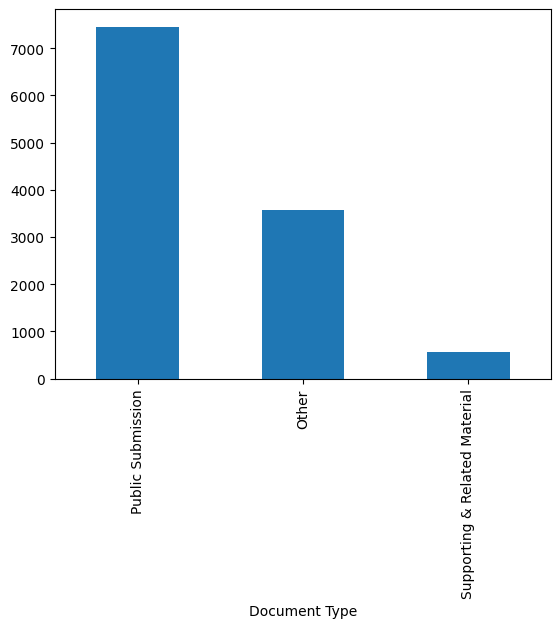

In [ ]:
manual_data['Document Type'].value_counts().plot.bar()

<Axes: xlabel='Document Subtype'>

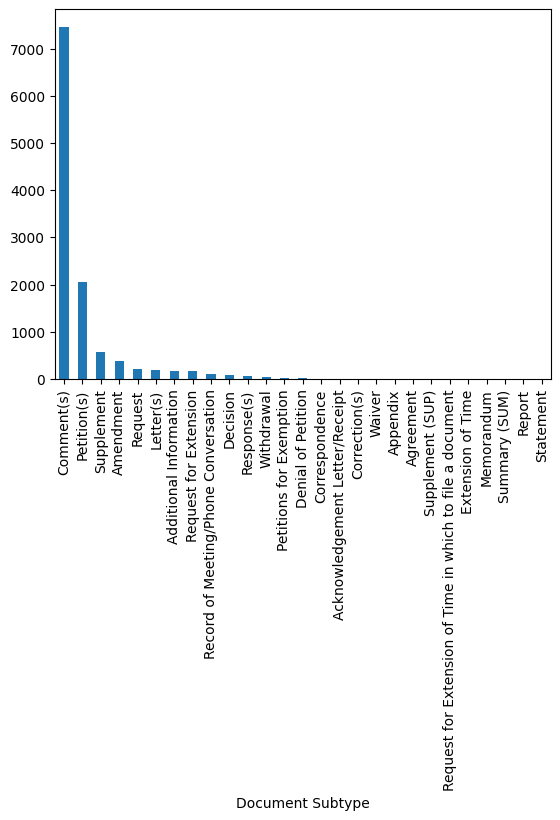

In [ ]:
manual_data['Document Subtype'].value_counts().plot.bar()

### Extract Only Comments(s) and Public Comment

In [19]:
manual_data = manual_data[manual_data['Document Subtype'].isin(['Comment(s)', 'Public Comment'])]
manual_data.shape

(7454, 60)

## Remove Stop words for analysis

In [22]:
# Load stopwords in English
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
# Function to clean text and remove stopwords
def remove_stopwords(text):
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Split the text into words and remove stopwords
    filtered_words = [word for word in text.split() if word not in stop_words]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

# Apply function to remove stopwords from the 'comment_text' column
manual_data['cleaned_comment'] = manual_data['Comment'].apply(remove_stopwords)

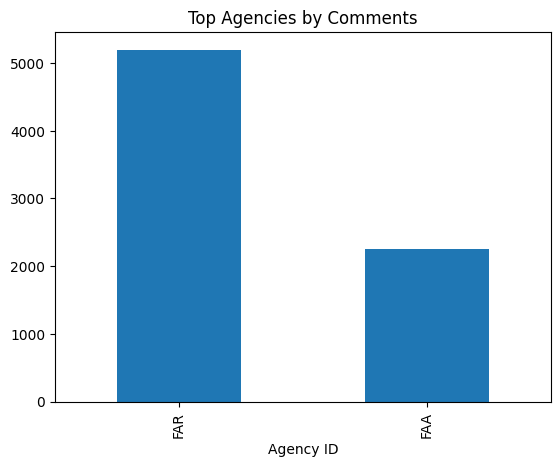

In [24]:
manual_data['Agency ID'].value_counts().head(20).plot.bar()
plt.title("Top Agencies by Comments")
plt.show()

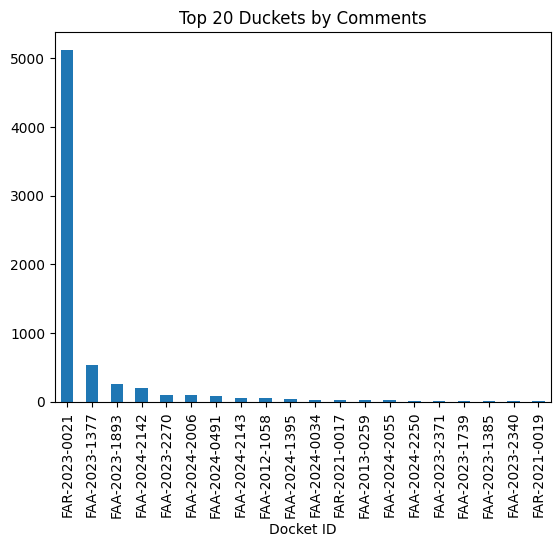

In [ ]:
manual_data['Docket ID'].value_counts().head(20).plot.bar()
plt.title("Top 20 Duckets by Comments")
plt.show()

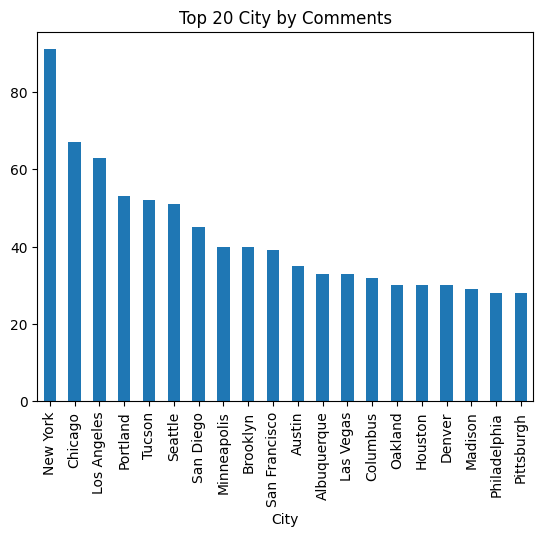

In [ ]:
manual_data['City'].value_counts().head(20).plot.bar()
plt.title("Top 20 City by Comments")
plt.show()

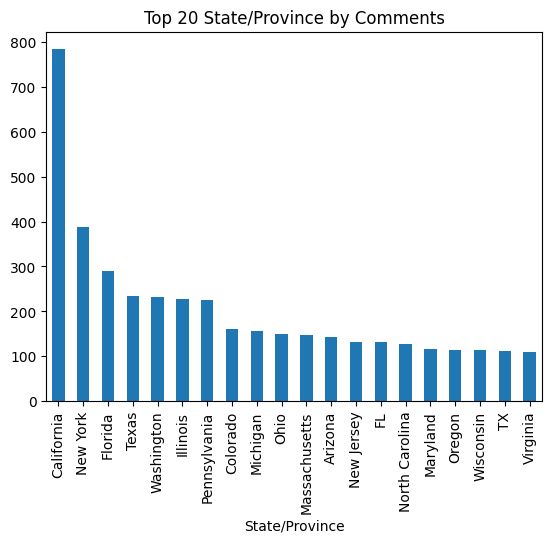

In [ ]:
manual_data['State/Province'].value_counts().head(20).plot.bar()
plt.title("Top 20 State/Province by Comments")
plt.show()

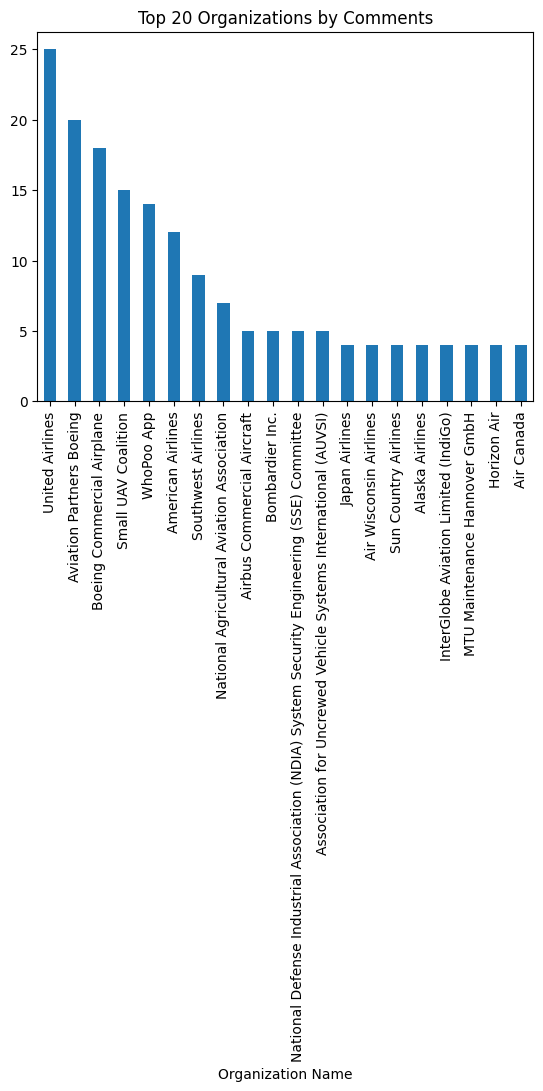

In [ ]:
manual_data['Organization Name'].value_counts().head(20).plot.bar()
plt.title("Top 20 Organizations by Comments")
plt.show()

### Word Frequency Analysis

F:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


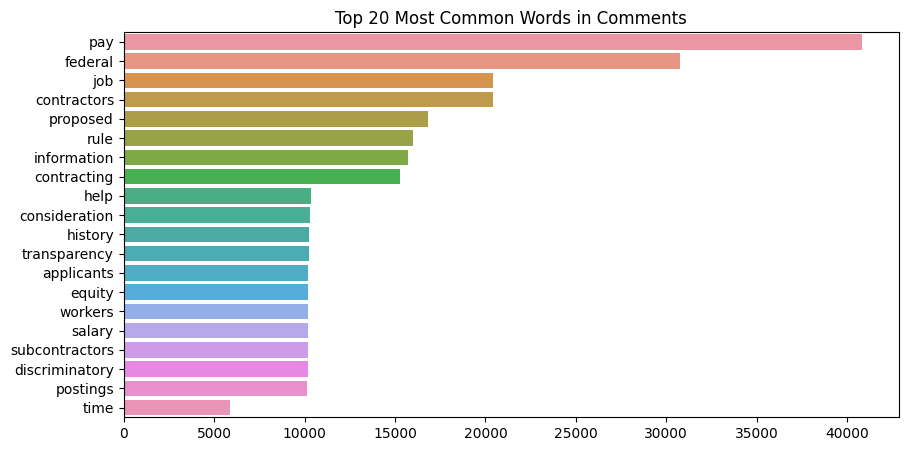

In [ ]:
all_words = ' '.join(manual_data['cleaned_comment'])
word_freq = Counter(all_words.split())

# Plotting Most Common Words
most_common_words = dict(word_freq.most_common(20))
plt.figure(figsize=(10,5))
sns.barplot(x=list(most_common_words.values()), y=list(most_common_words.keys()))
plt.title("Top 20 Most Common Words in Comments")
plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
F:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


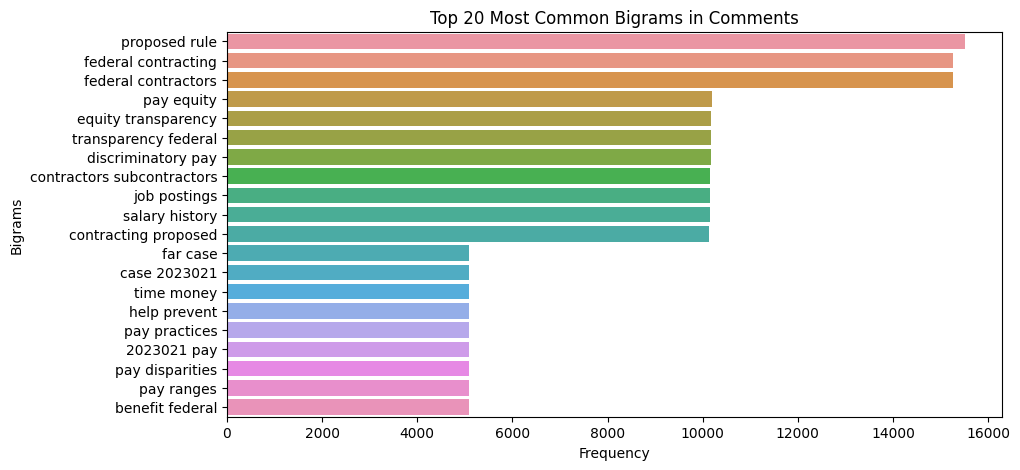

In [ ]:
from nltk import word_tokenize, bigrams

nltk.download('punkt')

def plot_top_bigrams(df, text_column='cleaned_comment', num_bigrams=20):
    # Join all text together
    all_words = ' '.join(df[text_column])

    # Tokenize and extract bigrams
    tokens = word_tokenize(all_words)
    bigram_list = list(bigrams(tokens))

    # Count bigrams
    bigram_freq = Counter(bigram_list)

    # Get the most common bigrams
    most_common_bigrams = dict(bigram_freq.most_common(num_bigrams))

    # Prepare bigrams for plotting
    bigrams_text = [' '.join(bigram) for bigram in most_common_bigrams.keys()]
    bigrams_counts = list(most_common_bigrams.values())

    # Plot the bigrams
    plt.figure(figsize=(10, 5))
    sns.barplot(x=bigrams_counts, y=bigrams_text)
    plt.title(f"Top {num_bigrams} Most Common Bigrams in Comments")
    plt.xlabel("Frequency")
    plt.ylabel("Bigrams")
    plt.show()

# Usage
plot_top_bigrams(manual_data)

### Word Cloud of Comments

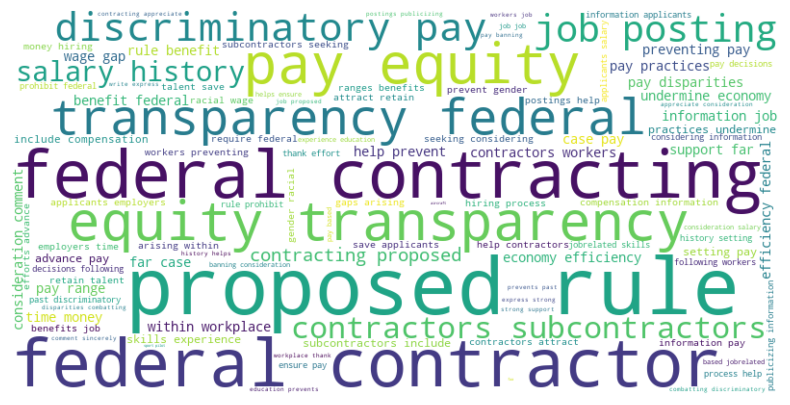

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Interpretation of above word cloud as my Understanding

1. **Identifying Key Topics and Concerns**:
   - The largest words in the cloud, such as **"federal contracting," "proposed rule," "pay equity,"** and **"transparency,"** indicate the most common terms. These words likely represent the primary themes or focus areas in the comments.
   - **"Discriminatory pay," "salary history,"** and **"job posting"** are also prominent, suggesting that many comments are concerned with pay practices, fairness, and equity in federal contracting.

2. **Understanding Public Sentiment**:
   - Terms like **"discriminatory," "equity,"** and **"transparency"** reflect public interest in fairness and openness in the contracting process.
   - The prominence of **"proposed rule"** implies that there’s significant discussion or reaction to a new rule that may impact these areas.

3. **Inferring Subtopics**:
   - Words like **"contractors," "subcontractors," "workers,"** and **"employers"** indicate that commenters are likely discussing specific groups impacted by the regulation.
   - Terms related to hiring practices, such as **"job posting," "salary history,"** and **"compensation,"** suggest that the regulation may include provisions addressing hiring transparency or pay equity.

4. **Spotting Potential Concerns or Support**:
   - Phrases like **"preventing pay disparities"** and **"attract retain talent"** may imply support for measures that promote equitable pay and talent retention.
   - Conversely, words like **"discriminatory"** could point to concerns about potential issues in the hiring process or contracting practices.

5. **Overall Interpretation**:
   - This word cloud reveals that the public comments on the federal regulation focus heavily on equity, transparency, and non-discriminatory practices in federal contracting. The public is likely advocating for policies that prevent pay discrimination, ensure fairness, and improve the transparency of federal contracts.

### Theme Identification & Insight Extraction

##### Topic Modeling:

 - Apply algorithms like Latent Dirichlet Allocation (LDA) using gensim to uncover underlying themes.

##### Clustering:

- Use K-Means or Hierarchical Clustering to group similar comments.

##### Keyword Extraction:

- Utilize RAKE, TF-IDF, or TextRank to extract significant keywords from comments.

##### Insight Generation:

- Summarize key themes and notable patterns from the analysis.
- Identify areas of strong support or concern among the public.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize Text
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(manual_data['cleaned_comment'])

# LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(dtm)

# Displaying the topics and top words
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])  # Top 10 words per topic

Topic #1:
['procurement', 'gap', 'discrimination', 'wages', 'paid', 'fair', 'information1', 'adrelated', 'women', 'equal']
Topic #2:
['equity', 'transparency', 'proposed', 'contracting', 'rule', 'information', 'contractors', 'job', 'federal', 'pay']
Topic #3:
['aviation', 'maintenance', 'nprm', 'inspection', 'flight', 'safety', 'proposed', 'faa', 'ad', 'aircraft']
Topic #4:
['speed', 'light', 'faa', 'proposed', 'safety', 'training', 'pilots', 'pilot', 'sport', 'aircraft']
Topic #5:
['proposed', 'docket', 'spacex', 'launch', 'space', 'ad', 'faa', 'attached', 'rudder', 'aircraft']


To explain these topics to stakeholders in a clear and concise way, you’ll want to focus on the main themes emerging from each topic. Here’s a breakdown of each topic with suggested explanations:

---

### **Topic #1: Employment Equity and Wage Fairness**
   - **Explanation**: This topic centers around concerns related to **employment equity**, specifically within government procurement processes. Key issues include **wage gaps, fair pay, and discrimination**, especially as they pertain to women in the workforce.
   - **Keywords**: *procurement, gap, discrimination, wages, fair, women, equal*
   - **Interpretation**: The public is focused on ensuring fair treatment and transparency in wages, with an emphasis on eliminating discrimination in hiring and pay.

### **Topic #2: Federal Contracting and Transparency**
   - **Explanation**: This topic highlights public concerns about **transparency and fairness in federal contracting**. There’s an interest in how the proposed regulations will impact **job equity, pay standards, and contractor obligations** in the federal space.
   - **Keywords**: *equity, transparency, contracting, rule, contractors, job, federal, pay*
   - **Interpretation**: Stakeholders are looking for reassurance that federal contracts will be awarded in a fair, equitable, and transparent manner. There is an expectation that this regulation could set standards for **fair pay and job equity**.

### **Topic #3: Aviation Safety Regulations (Maintenance and Inspections)**
   - **Explanation**: This topic reflects specific concerns about **aviation safety** related to **aircraft maintenance and inspection standards**. Comments mention the FAA’s role in maintaining **flight safety** and address **proposed changes in inspection protocols**.
   - **Keywords**: *aviation, maintenance, nprm (Notice of Proposed Rulemaking), inspection, flight, safety, faa, aircraft*
   - **Interpretation**: The public has a vested interest in ensuring stringent maintenance and inspection standards. This topic suggests that safety issues within aviation are a top priority, with many looking to the FAA to enforce high standards.

### **Topic #4: Pilot Safety and Training Standards**
   - **Explanation**: The focus of this topic is on **safety training standards for pilots**, particularly in areas involving **sport aircraft and light aircraft**. It also addresses the FAA's role in establishing safety guidelines for **pilot training**.
   - **Keywords**: *speed, light, faa, safety, training, pilots, pilot, sport, aircraft*
   - **Interpretation**: There’s a strong demand for safety and training regulations for pilots, especially concerning lighter, sport aircraft, where additional safety measures may be required. Public opinion suggests there’s concern over pilot preparedness and the FAA's responsibility in ensuring safety in this area.

### **Topic #5: Space Launch Safety and FAA Oversight**
   - **Explanation**: This topic covers **regulations around space launches**, focusing on companies like SpaceX and the safety protocols associated with **spacecraft launches and related FAA oversight**. There is mention of specific elements such as the **rudder on spacecraft**.
   - **Keywords**: *spacex, launch, space, faa, aircraft*
   - **Interpretation**: The public is interested in the FAA’s regulatory role in space exploration, particularly regarding safety protocols for commercial launches. This suggests a rising concern about the **safety of space launches** and the FAA's responsibilities as the regulatory authority.

---

### **Overall Suggested Framing for Stakeholders**

1. **Public Concerns about Fairness and Transparency**: Topics 1 and 2 reveal a strong public interest in issues of fairness and transparency within both employment and federal contracting processes. Stakeholders should consider whether the proposed regulations adequately address concerns about discrimination, wage gaps, and equitable contracting.

2. **Aviation and Pilot Safety**: Topics 3 and 4 reflect the public's emphasis on strict safety standards for aviation, including both aircraft maintenance and pilot training. Stakeholders in aviation may need to review the adequacy of these proposed standards to satisfy public demand for safety and FAA oversight.

3. **Emerging Focus on Space Regulation**: Topic 5 highlights growing public interest in FAA regulations on space launches, pointing to an increased awareness of and demand for regulatory oversight in this new frontier. This insight can guide policymakers in assessing the comprehensiveness of FAA regulations in space travel and exploration.

---

### **Conclusion**

Present these findings to illustrate the breadth of public sentiment and key areas of concern, demonstrating how public comments reflect both long-standing issues (like wage fairness) and emerging topics (such as space regulation).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def kmeans_clustering(texts, num_clusters=5):
    # Vectorize texts
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # Fit K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)

    # Add cluster labels to DataFrame
    labels = kmeans.labels_
    return labels, kmeans

manual_data['cluster_label'], kmeans_model = kmeans_clustering(manual_data['cleaned_comment'], num_clusters=5)

F:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
manual_data['cluster_label'].value_counts()

cluster_label
2    5081
0    1422
3     431
1     397
4     123
Name: count, dtype: int64

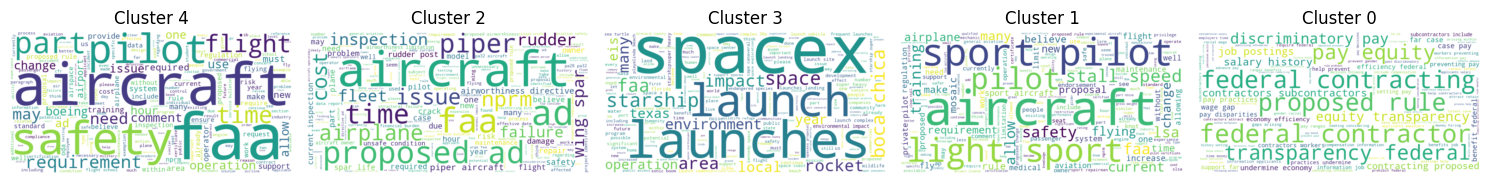

In [ ]:
def plot_wordclouds_by_cluster(df, cluster_column='cluster_label', text_column='cleaned_comment'):
    # Determine unique clusters
    clusters = df[cluster_column].unique()
    num_clusters = len(clusters)

    # Set up the subplot grid
    fig, axes = plt.subplots(1, num_clusters, figsize=(15, 10))
    axes = axes.flatten()

    # Generate a word cloud for each cluster
    for idx, cluster in enumerate(clusters):
        # Filter the text data for the current cluster
        cluster_texts = df[df[cluster_column] == cluster][text_column]
        # Combine all text in the cluster into a single string
        combined_text = ' '.join(cluster_texts)

        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

        # Plot the word cloud
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].axis('off')
        axes[idx].set_title(f'Cluster {cluster}')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_wordclouds_by_cluster(manual_data)

Based on the word clouds from each cluster, here’s an executive summary of the main themes for each cluster identified by KMeans clustering:

### Executive Summary of Clusters

#### **Cluster 0: Federal Contracting and Wage Equity**
   - **Key Themes**: The terms "federal," "contracting," "proposed rule," "transparency," "pay," "equity," and "discrimination" are prominent.
   - **Interpretation**: This cluster reflects concerns around federal contracting processes, specifically regarding issues of transparency, fair pay, equity, and anti-discrimination measures. The public seems focused on ensuring fairness in wage practices, especially in federal contracting environments, and is concerned with how the proposed rule will address these issues.

#### **Cluster 1: Light Aircraft and Pilot Safety Standards**
   - **Key Themes**: Words like "sport," "pilot," "aircraft," "light," and "safety" appear frequently.
   - **Interpretation**: This cluster is primarily focused on safety standards and regulations for light aircraft and sport pilots. The public has concerns about training requirements, safety protocols, and overall regulatory measures that ensure safe operations for this specific type of aviation.

#### **Cluster 2: Aircraft Maintenance and Inspection Requirements**
   - **Key Themes**: Terms such as "aircraft," "faa," "inspection," "proposed," "requirement," and "safety" are prevalent.
   - **Interpretation**: This cluster deals with issues surrounding maintenance and inspection standards in the aviation industry. Comments are focused on ensuring rigorous safety checks and FAA oversight for aircraft to maintain safety standards. This suggests a significant public interest in ensuring high maintenance standards to avoid potential failures.

#### **Cluster 3: Space Launches and Environmental Impact**
   - **Key Themes**: Prominent words include "spacex," "launch," "launches," "starship," "impact," and "texas."
   - **Interpretation**: This cluster is dedicated to concerns around commercial space launches, especially those conducted by SpaceX. Key areas of focus include the environmental impact of launches, the safety of local communities, and regulatory oversight by authorities such as the FAA. Public comments emphasize the need for responsible space exploration practices.

#### **Cluster 4: General Aviation Safety and Pilot Requirements**
   - **Key Themes**: Common words include "aircraft," "pilot," "flight," "faa," and "safety."
   - **Interpretation**: This cluster is broadly concerned with general aviation safety, covering topics like pilot requirements, FAA safety guidelines, and specific operational requirements for pilots and aircraft. There is a strong public interest in ensuring that pilots and operators adhere to rigorous safety standards, and in the FAA's role in regulating these standards.

---

### Summary

The clusters indicate that public comments are highly focused on themes of **fairness in federal contracting, aviation safety, and responsible space exploration**.

1. **Federal Contracting Concerns**: There is significant attention on ensuring equity, transparency, and anti-discrimination in federal contracting.
2. **Aviation Safety Standards**: A recurring theme involves safety standards across various aviation areas, including light aircraft, pilot requirements, and maintenance protocols.
3. **Space Exploration and Environmental Impact**: With the rise of commercial space launches, there is a growing public demand for responsible practices in space exploration.

This clustering analysis reveals critical insights into areas where the public expects thorough regulatory oversight and fair practices, indicating priorities for policymakers.

### Keyword Extraction Using RAKE, TF-IDF, and TextRank


##### RAKE

In [ ]:
# !pip install rake_nltk

In [ ]:
from rake_nltk import Rake

def rake_keyword_extraction(text, num_keywords=10):
    r = Rake(stopwords=stop_words)
    r.extract_keywords_from_text(text)
    try:
        kw = r.get_ranked_phrases()[:num_keywords][0]
    except:
        kw = ""
    return kw

manual_data['rake_keywords'] = manual_data['cleaned_comment'].apply(lambda x: rake_keyword_extraction(x))

### Plot Top Keywords by RAKE Method

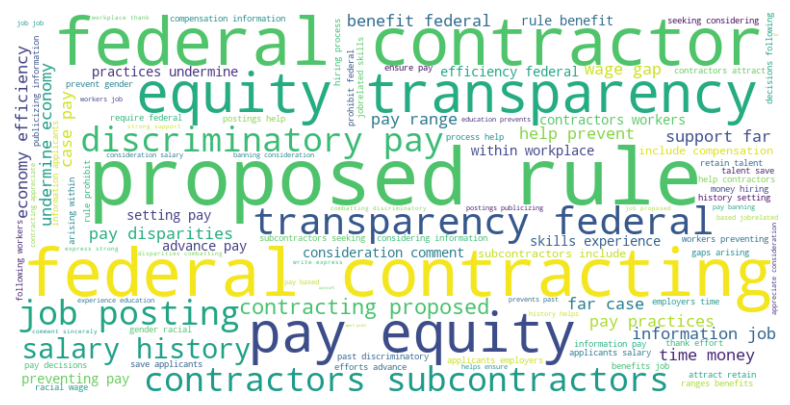

In [ ]:
all_words_1 = ' '.join(manual_data['rake_keywords'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### We can Also use TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_keyword_extraction(texts, num_keywords=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    feature_array = vectorizer.get_feature_names_out()

    tfidf_keywords = []
    for row in X.toarray():
        top_indices = row.argsort()[-num_keywords:]
        tfidf_keywords.append([feature_array[i] for i in top_indices])

    return tfidf_keywords

manual_data['tfidf_keywords'] = tfidf_keyword_extraction(manual_data['cleaned_comment'])

In [ ]:
manual_data['tfidf_keywords'].values

array([list(['public', 'writing', 'increasing', 'response', 'today', 'keeping', '60', 'mandatory', 'pilots', 'airline']),
       list(['law', 'accordance', 'questions', 'flight', 'air', 'exemption', 'force', 'drug', '14', 'cfr']),
       list(['contact', 'accordance', 'feet', 'questions', 'air', 'flight', 'exemption', 'force', '14', 'cfr']),
       ...,
       list(['services', 'includes', 'items', 'role', 'agencies', 'far', 'supply', 'location', '40', 'security']),
       list(['work', 'certain', 'open', 'act', 'equipment', 'cases', 'services', 'supply', 'security', 'extended']),
       list(['category', 'parts', 'recommend', '20', 'supply', 'requirements', 'programs', 'special', '40', 'security'])],
      dtype=object)

##### TextRank

Note: This is time consuming step, to give you just an idea, I ran on randon 20 comments

In [ ]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

def textrank_keyword_extraction(text, num_keywords=5):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([text])
    terms = vectorizer.get_feature_names_out()

    # Build term co-occurrence matrix
    matrix = (X.T * X)
    matrix.setdiag(0)

    # Build graph and apply PageRank
    graph = nx.from_scipy_sparse_matrix(matrix)
    scores = nx.pagerank(graph)

    # Rank keywords based on TextRank
    ranked_terms = sorted(((scores[i], term) for i, term in enumerate(terms)), reverse=True)
    return [term for score, term in ranked_terms[:num_keywords]]

# Usage example
manual_data['cleaned_comment'].sample(n = 20).apply(lambda x: textrank_keyword_extraction(x))

C:\Users\Admin\AppData\Local\Temp\ipykernel_23664\1110104936.py:14: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  graph = nx.from_scipy_sparse_matrix(matrix)


4370                     [time, hours, flying, zero, want]
3540              [rudder, aircraft, faa, ad, information]
2537                [pay, federal, job, contractors, rule]
1974                [pay, federal, contractors, job, rule]
995                 [pay, federal, job, contractors, rule]
2074             [transport, gmbh, european, dhl, comment]
4048                [pay, federal, contractors, job, rule]
4313                [pay, federal, job, contractors, rule]
3822                [pay, federal, job, contractors, rule]
2812                [pay, federal, job, contractors, rule]
362           [station, repair, medical, testing, mexican]
4071                [pay, federal, job, contractors, rule]
463                 [pay, federal, job, contractors, rule]
4926                      [standards, faa, epa, cfr, nvpm]
4351                [pay, federal, job, contractors, rule]
5399     [წარმოადგენს, ჩვენი, საჰაერო, საცობი, პროფესორ...
5994            [rudder, quadrant, planes, inspection, a

### Topic and Aspect Detection
For topic and aspect detection, we can use transformer-based topic modeling techniques. Hugging Face Transformers does not directly offer topic modeling, but we can use a Zero-Shot Classification approach with models like facebook/bart-large-mnli to classify each comment into predefined topics or aspects.

Defining Topics and Aspects: Since these comments are technical, we’ll specify a list of possible topics and aspects that are relevant, such as "safety", "federal contracting", "space exploration", and "aviation maintenance".

In [35]:
from transformers import pipeline

# Initialize zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define possible topics or aspects
topics = ["safety", "federal contracting", "space exploration", "aviation maintenance", "equity", "pilot training"]

# Function to detect the main topic or aspect
def detect_topic_aspect(text):
    result = classifier(text, candidate_labels=topics)
    # Select the topic with the highest confidence score
    return result['labels'][0]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### For simplicty i am executing on 10 comments only

In [37]:
temp = manual_data.sample(n = 10)

In [38]:
# Apply topic/aspect detection
temp['topic_aspect'] = temp['cleaned_comment'].apply(detect_topic_aspect)

In [39]:
# Display sample results
temp[['cleaned_comment', 'topic_aspect']].head()

,cleaned_comment,topic_aspect
2724,retired federal government employee read incre...,federal contracting
656,write express strong support far case 2023021 ...,federal contracting
2824,write express strong support far case 2023021 ...,federal contracting
1628,write express strong support far case 2023021 ...,federal contracting
4536,write express strong support far case 2023021 ...,federal contracting


In [40]:
temp['topic_aspect'].value_counts()

,count
topic_aspect,
federal contracting,8
safety,1
aviation maintenance,1


### Sentiment Analysis

Use pre-trained models from libraries like TextBlob, VADER, or transformers (e.g., BERT-based models) to assess sentiment polarity (positive, negative, neutral).

F:\Users\Admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


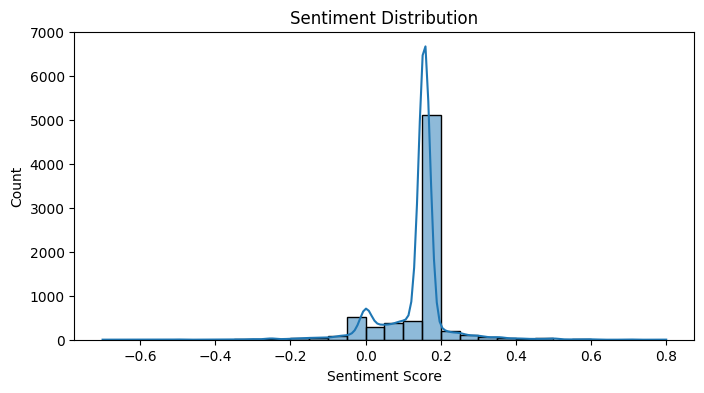

In [ ]:
from textblob import TextBlob

# Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Ranges from -1 (negative) to +1 (positive)

manual_data['sentiment'] = manual_data['cleaned_comment'].apply(get_sentiment)

# Visualize sentiment distribution
plt.figure(figsize=(8, 4))
sns.histplot(manual_data['sentiment'], bins=30, kde=True)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Score")
plt.show()

### Word Cloud of Positive Sentiments - comments

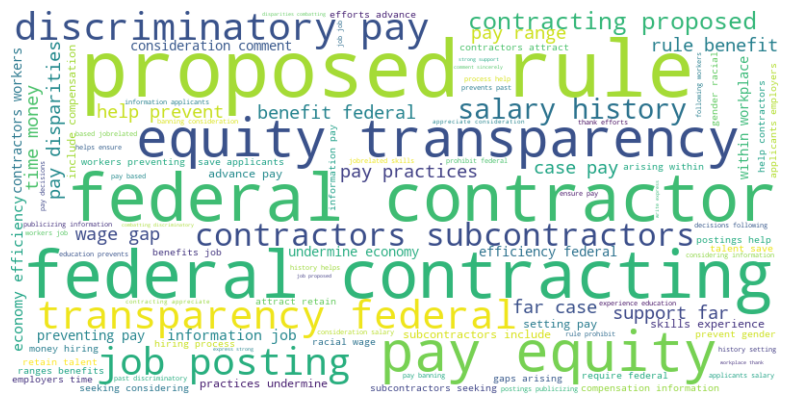

In [ ]:
all_words_1 = ' '.join(manual_data[manual_data['sentiment'] > 0]['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This word cloud represents the most frequent terms in public comments that have a **positive sentiment** regarding a proposed federal regulation. Here’s an interpretation based on the positive sentiment context:

1. **Support for Transparency and Equity**:
   - Words like **"proposed rule," "equity,"** and **"transparency"** are prominent, which suggests strong support for the regulation's emphasis on fairness and open practices in federal contracting.
   - The terms **"pay equity," "transparency federal,"** and **"discriminatory pay"** imply that commenters are positively responding to potential measures that address pay disparities and improve transparency.

2. **Encouragement for Anti-Discriminatory Practices**:
   - Words like **"discriminatory," "pay practices,"** and **"salary history"** suggest that commenters appreciate regulatory efforts aimed at reducing discriminatory practices, such as considering an applicant's salary history in hiring processes.
   - The presence of **"wage gap"** and **"pay disparities"** implies that the public values regulatory interventions that might work towards closing gender or racial wage gaps.

3. **Interest in Job Posting and Hiring Practices**:
   - The inclusion of **"job posting"** and **"salary history"** hints that the proposed rule may address hiring transparency and job posting standards, which commenters seem to view positively.
   - **"Help prevent"** and **"consideration"** reflect a positive view of measures that promote fair hiring practices, possibly aimed at creating a level playing field for all applicants.

### Word Cloud of Neutral Sentiments - comments

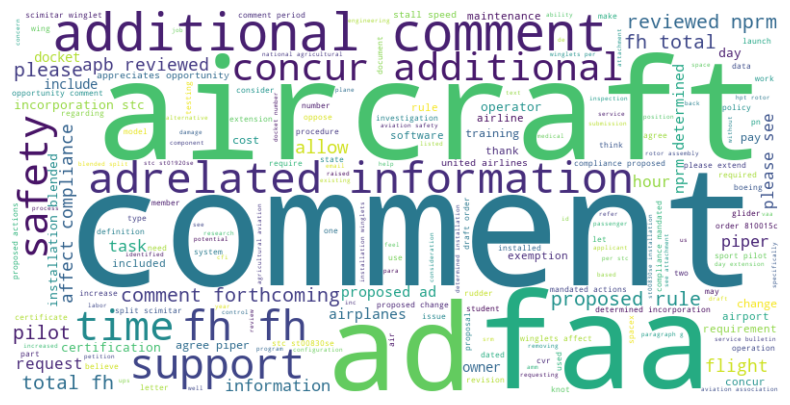

In [ ]:
all_words_1 = ' '.join(manual_data[manual_data['sentiment'] == 0]['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud of Negative Sentiments - comments

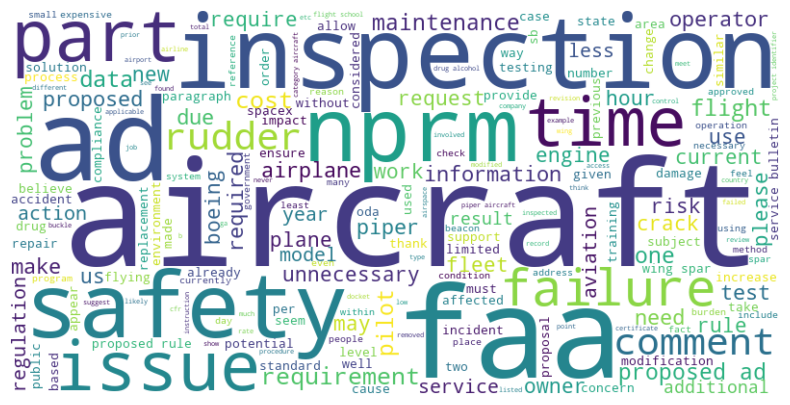

In [ ]:
all_words_1 = ' '.join(manual_data[manual_data['sentiment'] < 0]['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

1. **Concerns about Maintenance Standards**: The word cloud suggests concerns about aircraft maintenance standards, possibly due to cost-cutting measures or inadequate inspections.
2. **Safety Concerns**: There seems to be a strong focus on safety issues, including potential failures and the need for stricter regulations.
3. **Regulatory Burden**: The word cloud indicates frustration with regulatory requirements, particularly those perceived as unnecessary or overly burdensome.
4. **Cost-Benefit Analysis**: There might be concerns about the cost of complying with regulations and the potential benefits to safety.

Overall, the word cloud reflects a negative sentiment towards the current state of aircraft maintenance and safety regulations. There are concerns about potential failures, safety risks, and the burden of regulations.

### Sentiment Analysis using Transformer Model
We can use a pre-trained sentiment analysis model like distilbert-base-uncased-finetuned-sst-2-english for this task.

In [41]:
# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [45]:
temp = manual_data.drop_duplicates(subset = ['cleaned_comment']).sample(n = 10)

In [46]:
# Perform sentiment analysis on each comment
temp['sentiment_BERT'] = temp['cleaned_comment'].apply(lambda x: sentiment_analyzer(x)[0]['label'])

# Display sample results
temp[['cleaned_comment', 'sentiment_BERT']].head()


,cleaned_comment,sentiment_BERT
255,write express strong support far case 2023021 ...,NEGATIVE
1456,write express strong support far case 2023021 ...,NEGATIVE
2667,support position carol carpenter rainbow aviation,POSITIVE
4976,write express strong support far case 2023021 ...,NEGATIVE
2516,write express strong support far case 2023021 ...,NEGATIVE


In [47]:
temp['sentiment_BERT'].value_counts()

,count
sentiment_BERT,
NEGATIVE,9
POSITIVE,1


##### Insight Generation

In [ ]:
import numpy as np
from collections import Counter

def generate_insights(df, cluster_column='cluster_label'):
    insights = {}

    # Cluster Summary
    cluster_counts = Counter(df[cluster_column])
    insights['cluster_summary'] = dict(cluster_counts)

    # Keyword Summary
    all_keywords = [kw for sublist in df['tfidf_keywords'] for kw in sublist]
    keyword_counts = Counter(all_keywords)
    insights['top_keywords'] = keyword_counts.most_common(10)

    # Sentiment Summary
    if 'sentiment' in df.columns:
        avg_sentiment = np.mean(df['sentiment'])
        insights['average_sentiment'] = avg_sentiment
        positive_comments = df[df['sentiment'] > 0]
        negative_comments = df[df['sentiment'] < 0]
        insights['positive_comments'] = len(positive_comments)
        insights['negative_comments'] = len(negative_comments)

    # Display insights
    print("Cluster Summary:")
    print(insights['cluster_summary'])

    print("\nTop Keywords:")
    print(insights['top_keywords'])

    if 'average_sentiment' in insights:
        print("\nSentiment Analysis:")
        print(f"Average Sentiment Score: {insights['average_sentiment']}")
        print(f"Positive Comments: {insights['positive_comments']}")
        print(f"Negative Comments: {insights['negative_comments']}")

    return insights

insights = generate_insights(manual_data)

Cluster Summary:
{0: 1422, 3: 431, 4: 123, 1: 397, 2: 5081}

Top Keywords:
[('federal', 5098), ('pay', 5095), ('contractors', 5073), ('job', 5070), ('information', 5048), ('contracting', 5033), ('rule', 5023), ('proposed', 5005), ('postings', 4936), ('salary', 4293)]

Sentiment Analysis:
Average Sentiment Score: 0.13553055863574892
Positive Comments: 6723
Negative Comments: 356


### Bot vs. Human Comment Differentiation:

##### Features to Consider:

- Language Patterns: Bots might use repetitive or overly formal language.
- Timing Patterns: High-frequency submissions in short time frames.
- Metadata Analysis: Check for user activity patterns.

##### Techniques:

- Train a classifier using labeled data (if available) to distinguish between bot and human comments.
- Utilize anomaly detection methods to identify unusual patterns indicative of bots.

##### Visualization:

- Display sentiment distribution with pie charts or bar graphs.
- Correlate sentiment with themes to provide deeper insights.

### Simple Approach

In [ ]:
import numpy as np

# Simple heuristics for bot detection
def detect_bot(comment_text):
    # Rule-based example: if text is repetitive or overly similar to others, flag as bot
    words = comment_text.split()
    unique_word_ratio = len(set(words)) / len(words) if len(words) > 0 else 0
    is_bot = unique_word_ratio < 0.3  # Arbitrary threshold; adjust based on data exploration
    return is_bot

manual_data['is_bot'] = manual_data['cleaned_comment'].apply(detect_bot)

# Analyze bot-like comments
bot_comments = manual_data[manual_data['is_bot']]
print(f"Potential bot comments: {len(bot_comments)} out of {len(manual_data)}")

Potential bot comments: 2 out of 7454


In [ ]:
manual_data[manual_data['is_bot'] == True][['Comment']]

,Comment
346,no
527,no


### Check the Count of each comment

- The comments which are more than once, we will analyze those comments

In [ ]:
comments = manual_data[['Comment', 'Comment on Document ID']].groupby("Comment").count().reset_index()
comments.columns = ['Comment', 'Count']
comments = comments.sort_values(by = 'Count')
comments_to_check = comments[comments['Count'] > 1]
comments_to_check

,Comment,Count
3353,i write to express my strong support for far c...,2
3339,i write to express my strong support for far c...,2
3088,i write to express my strong support for far c...,2
128,ad 20202616 was geared exclusively towards tho...,2
3633,i write to express my strong support for far c...,2
...,...,...
247,apb has reviewed the nprm and has determined t...,4
5098,i write to express my strong support for far c...,6
6344,small uav coalition comments,6
493,concur no additional comment will be forthcoming,10


In [ ]:
manual_data[manual_data['Comment'] == comments_to_check['Comment'].values[0]]

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)",cleaned_comment
354,FAR-2023-0021-0171,FAR,FAR-2023-0021,lto-owfq-3qys,Public Submission,2024-03-25T04:00Z,False,NaN,NaN,Comment on FR Doc # 2024-01343,NaN,NaN,False,FAR-2023-0021-0001,NaN,NaN,NaN,2024-03-12T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Johan,Greenhaus,New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i write to express my strong support for far c...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ...",write express strong support far case 2023021 ...
2951,FAR-2023-0021-2768,FAR,FAR-2023-0021,lua-agwz-lntz,Public Submission,2024-03-29T04:00Z,False,NaN,NaN,Comment on FR Doc # 2024-01343,NaN,NaN,False,FAR-2023-0021-0001,NaN,NaN,NaN,2024-03-27T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Johan,Greenhaus,New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i write to express my strong support for far c...,NaN,NaN,NaN,NaN,NaN,NaN,"pageCount, Page Count, Number of pages In the ...",write express strong support far case 2023021 ...


In [ ]:
manual_data[manual_data['Comment'] == comments_to_check['Comment'].values[-1]]

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)",cleaned_comment
2077,FAA-2023-1053-0013,FAA,FAA-2023-1053,lx3-gxi9-7g8i,Public Submission,2024-06-06T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-1053-0009,NaN,NaN,NaN,2024-06-06T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-105...,NaN,concur additional comment forthcoming
2940,FAA-2023-1488-0014,FAA,FAA-2023-1488,lxc-enry-cnjf,Public Submission,2024-06-13T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplanes,NaN,NaN,False,FAA-2023-1488-0011,NaN,NaN,NaN,2024-06-12T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplanes,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-148...,NaN,concur additional comment forthcoming
4022,FAA-2023-2151-0016,FAA,FAA-2023-2151,m2n-laul-vs0w,Public Submission,2024-10-24T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-2151-0011,NaN,NaN,NaN,2024-10-24T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-215...,NaN,concur additional comment forthcoming
5395,FAA-2024-0028-0009,FAA,FAA-2024-0028,lt7-jqae-6nmw,Public Submission,2024-02-29T05:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2024-0028-0001,NaN,NaN,NaN,2024-02-29T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2024-002...,NaN,concur additional comment forthcoming
5464,FAA-2024-0036-0003,FAA,FAA-2024-0036,lte-x7ez-p56p,Public Submission,2024-03-06T05:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2024-0036-0001,NaN,NaN,NaN,2024-03-05T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2024-003...,NaN,concur additional comment forthcoming
5504,FAA-2024-0043-0003,FAA,FAA-2024-0043,lto-vt88-tuq9,Public Submission,2024-03-13T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2024-0043-0001,NaN,NaN,NaN,2024-03-12T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,con

### Repeated Comments are Same comments but on Different Duckets and on Same time can be potential bot comments

In [ ]:
manual_data[manual_data['Comment'] == comments_to_check['Comment'].values[-2]]

,Document ID,Agency ID,Docket ID,Tracking Number,Document Type,Posted Date,Is Withdrawn?,Federal Register Number,FR Citation,Title,Comment Start Date,Comment Due Date,Allow Late Comments,Comment on Document ID,Effective Date,Implementation Date,Postmark Date,Received Date,Author Date,Related RIN(s),Authors,CFR,Abstract,Legacy ID,Media,Document Subtype,Exhibit Location,Exhibit Type,Additional Field 1,Additional Field 2,Topics,Duplicate Comments,OMB/PRA Approval Number,Page Count,Page Length,Paper Width,Special Instructions,Source Citation,Start End Page,Subject,First Name,Last Name,City,State/Province,Zip/Postal Code,Country,Organization Name,Submitter Representative,Representative's Address,"Representative's City, State & Zip",Government Agency,Government Agency Type,Comment,Category,Restrict Reason Type,Restrict Reason,Reason Withdrawn,Content Files,Attachment Files,"Display Properties (Name, Label, Tooltip)",cleaned_comment
2067,FAA-2023-1037-0007,FAA,FAA-2023-1037,lpw-xcrr-e34z,Public Submission,2023-12-08T05:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-1037-0006,NaN,NaN,NaN,2023-12-08T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-103...,NaN,concur additional comment forthcoming
3339,FAA-2023-1889-0004,FAA,FAA-2023-1889,log-4mkg-dnwf,Public Submission,2023-11-01T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-1889-0001,NaN,NaN,NaN,2023-11-01T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-188...,NaN,concur additional comment forthcoming
3347,FAA-2023-1892-0003,FAA,FAA-2023-1892,loo-poie-odwz,Public Submission,2023-11-07T05:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-1892-0001,NaN,NaN,NaN,2023-11-07T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-189...,NaN,concur additional comment forthcoming
4180,FAA-2023-2233-0003,FAA,FAA-2023-2233,lrj-jl5x-zg8f,Public Submission,2024-01-18T05:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2023-2233-0001,NaN,NaN,NaN,2024-01-18T05:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2023-223...,NaN,concur additional comment forthcoming
6653,FAA-2024-0463-0013,FAA,FAA-2024-0463,lvf-pxtj-v8e5,Public Submission,2024-04-25T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplane,NaN,NaN,False,FAA-2024-0463-0001,NaN,NaN,NaN,2024-04-25T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplane,NaN,NaN,NaN,NaN,NaN,concur no additional comment will be forthcoming,NaN,NaN,NaN,NaN,NaN,https://downloads.regulations.gov/FAA-2024-046...,NaN,concur additional comment forthcoming
8958,FAA-2024-1303-0003,FAA,FAA-2024-1303,lxy-y1sr-hkq1,Public Submission,2024-06-28T04:00Z,False,NaN,NaN,Comment from Boeing Commercial Airplanes,NaN,NaN,False,FAA-2024-1303-0001,NaN,NaN,NaN,2024-06-28T04:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comment(s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boeing Commercial Airplanes,NaN,NaN,NaN,NaN,NaN,con

### Using Zero-Shot Classification with Candidate Labels

We’ll use the zero-shot-classification pipeline from Hugging Face’s Transformers library. This approach works by asking the model to classify text into one of two labels: "bot-generated" or "human-written".

In [28]:
from transformers import pipeline

# Initialize zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define the candidate labels for bot vs human
candidate_labels = ["bot-generated", "human-written"]

# Function to classify text as bot or human
def detect_bot_or_human(text):
    text = str(text)

    if text == "" or text == " " or len(text) == 0:
        text = "no text"

    result = classifier(text, candidate_labels=candidate_labels)
    # Select the label with the highest confidence score
    return result['labels'][0]

## Just for a proof of concept I will apply on subset of data

In [31]:

temp = manual_data.sample(n = 10)

# Apply bot/human detection to each comment
temp['bot_or_human'] = temp['cleaned_comment'].apply(detect_bot_or_human)

In [32]:
# Display sample results
temp[['cleaned_comment', 'bot_or_human']].head()

,cleaned_comment,bot_or_human
10887,bit confusing figure comment strongly support ...,human-written
4999,write express strong support far case 2023021 ...,human-written
395,write express strong support far case 2023021 ...,human-written
3157,write express strong support far case 2023021 ...,human-written
6649,write express strong support recommended new a...,human-written


In [33]:
temp['bot_or_human'].value_counts()

,count
bot_or_human,
human-written,10


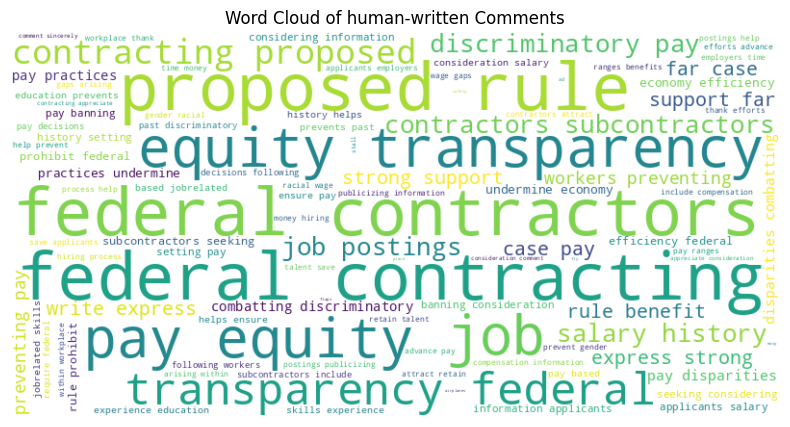

In [34]:
all_words_1 = ' '.join(temp[temp['bot_or_human'] == "human-written"]['cleaned_comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words_1)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of human-written Comments")
plt.axis('off')
plt.show()

### Tech Stack Recommendations

- Programming Language: Python
- Libraries:
    - Data Handling: pandas, numpy
    - Web Scraping: BeautifulSoup, requests
    - Text Processing: nltk, spaCy, gensim
    - Machine Learning: scikit-learn, tensorflow/keras or pytorch for advanced models
    - Visualization: matplotlib, seaborn, wordcloud
    - Sentiment Analysis: TextBlob, VADER, transformers (for BERT-based models)

- Environment:
    - Jupyter Notebook: For interactive analysis and visualization

- Version Control: Git with GitHub or BitBucket

- Deployment:
    - Cloud Services: AWS (S3, Lambda, SageMaker), Google Cloud, or Azure
    - CI/CD: GitHub Actions or similar for automated testing and deployment

### Integration with Large Language Models (LLMs):

##### Automation:
- We can utilize LLMs for automated data cleaning, preprocessing, and feature extraction.

##### Enhanced Analysis:
- We can leverage LLMs for more nuanced sentiment analysis and topic modeling.

##### Scalability:
- We will deploy LLM-based services on scalable infrastructure (e.g., AWS Lambda with serverless architecture) to handle large volumes of data efficiently.

##### Continuous Improvement:
- We will implement feedback loops where LLMs learn from new data to improve analysis accuracy over time.

### Large Language Models (LLMs)

Large Language Models (LLMs), such as those provided by Hugging Face, OpenAI, and Google, offer powerful tools to automate and enhance various steps in a data processing and analysis pipeline. Here’s how LLMs can be applied in different stages of a pipeline, along with their potential to elevate the quality and efficiency of insights from regulatory public comments.

---

### Key Applications of LLMs in the Pipeline

1. **Data Preprocessing and Cleaning**
   - **Language Models for Text Normalization**: LLMs can help with standardizing terminology and grammar across a dataset, which is particularly valuable when dealing with comments that might have typos, varying terminology, or industry-specific jargon.
   - **Entity Recognition and Masking**: LLMs like `bert-base-ner` can be used to identify named entities, such as companies, individuals, or locations, in regulatory comments. They can help anonymize sensitive data, ensuring compliance with privacy regulations.
   - **Bot Detection**: LLMs trained for classification tasks can be fine-tuned to distinguish between bot-generated and human-generated content. This is crucial in public comment analysis, as bot comments can skew sentiment analysis and topic modeling.

2. **Data Analysis and Feature Extraction**
   - **Sentiment Analysis**: LLMs fine-tuned on sentiment analysis datasets can provide nuanced sentiment scores that go beyond simple positive, negative, or neutral. They can identify subtleties in tone, which is essential in regulatory contexts where opinions may be complex.
   - **Aspect-Based Sentiment Analysis (ABSA)**: ABSA-enabled LLMs can break down sentiment by aspect, identifying specific areas of concern, such as "safety," "cost," or "compliance." This is particularly useful for regulatory analysis, as it allows analysts to see not only general sentiment but also how different aspects of a proposed rule are received.
   - **Keyword and Keyphrase Extraction**: LLMs like BERT or `roberta-base` can improve keyword extraction by understanding context. Using models for named entity recognition (NER) or keyphrase extraction, relevant keywords or bigrams can be identified more accurately than using frequency-based methods alone. This helps identify the core themes in the comments and builds a foundation for deeper insights.

3. **Advanced Topic Modeling and Theme Detection**
   - **Context-Aware Topic Modeling**: LLMs like BERT with topic modeling techniques (e.g., BERTopic) are more effective in generating coherent topics because they capture the semantic meaning of words within comments. This is crucial in regulatory text analysis, where themes can be subtle and require context to understand properly.
   - **Aspect-Based Topic Analysis**: Beyond general topics, LLMs can categorize comments into themes related to different aspects of a regulation. For instance, comments about "aviation safety" and "federal contracting transparency" could be grouped under separate clusters, providing a clearer picture of public concerns and interests by specific regulatory focus areas.
   - **Summarization**: Summarization models (e.g., `bart-large-cnn`, `t5-large`) can condense large volumes of text into concise summaries, capturing the core arguments and concerns without losing essential information. This allows analysts to rapidly understand the main points without needing to review each comment individually.

4. **Automation of Insight Generation**
   - **Human-Readable Summaries**: Using summarization models, LLMs can automatically generate summaries of public sentiment, key concerns, and areas of support or opposition for each cluster or topic. These summaries can be tailored to different stakeholders, providing concise insights for decision-makers.
   - **Trend Analysis Over Time**: By processing comments over time, LLMs can identify shifts in sentiment or topics, providing early indicators of changing public opinion. For example, if comments show a growing emphasis on “environmental concerns” over time, it may signal an emerging area of public focus.
   - **Identifying Policy Impact**: LLMs can categorize comments based on whether they reference potential positive or negative outcomes of the regulation. This allows policymakers to assess perceived impacts and address concerns proactively.

5. **Enhanced Reporting and Stakeholder Communication**
   - **Natural Language Generation for Reports**: LLMs can automatically generate narrative reports, translating analytical insights into readable summaries for non-technical stakeholders. This can be done in an automated or semi-automated way, reducing the time required to compile and distribute reports.
   - **Generating Examples for Illustrative Purposes**: LLMs can create hypothetical examples based on real comments, helping to illustrate public opinion in a way that’s more relatable. This can improve engagement and comprehension among stakeholders who need to understand the public’s concerns without deep technical expertise.

---

### How LLMs Elevate and Enhance the Pipeline

Incorporating LLMs into the pipeline provides several enhancements:

- **Efficiency Gains**: By automating time-consuming tasks like summarization, aspect-based sentiment analysis, and keyword extraction, LLMs allow analysts to focus on higher-level interpretation and strategy. This speeds up the time-to-insight, which is particularly valuable when analyzing large comment datasets.
  
- **Improved Accuracy and Contextual Understanding**: Traditional NLP methods often struggle with contextual nuances, especially in technical or regulatory language. LLMs trained on large, diverse datasets understand context and nuance better, leading to more accurate and meaningful insights.

- **Scalability for Large Datasets**: LLMs are capable of processing large volumes of text data efficiently. This scalability is essential for high-impact federal regulation dockets that may receive thousands of comments. An LLM-enhanced pipeline can handle these volumes while maintaining high-quality analysis.

- **Deeper Insights with Aspect and Topic Detection**: The ability to detect sentiment by specific aspects (like “cost” vs. “safety”) and to generate context-aware topics means that LLM-enhanced analysis is far more granular. Policymakers get a clear picture of public opinion on different facets of the regulation, allowing for targeted responses or modifications.

- **Human-Like Summarization and Explanation**: LLMs provide a human-like level of summarization and explanation. Summarized content becomes more relatable and easily understandable, bridging the gap between raw data and actionable insights for decision-makers.

- **Enhanced Detection of Bot Influence**: By using LLMs for bot detection, analysts can filter out bot-generated comments that may skew sentiment or topic analysis, resulting in more authentic and reliable insights.

### Potential Challenges and Considerations

While LLMs offer powerful capabilities, there are some challenges to consider:

- **Ethics and Bias**: LLMs trained on broad datasets may have inherent biases, which could affect sentiment analysis or topic modeling in regulatory contexts. Fine-tuning with domain-specific data is often required to mitigate this risk.
  
- **Cost and Resource Requirements**: Running large models on high volumes of data requires significant computational resources, especially when processing large public comment datasets. Cloud services (e.g., AWS) are often necessary for scalability but can be costly.

- **Interpretability**: Some LLMs operate as black boxes, making it difficult to understand exactly how they derived specific insights. This may be a limitation for regulatory settings where transparency is required.

---

### Summary

LLMs have the potential to transform the analysis of regulatory public comments by automating complex NLP tasks, enhancing the depth and accuracy of insights, and generating human-readable summaries. By applying LLMs throughout the pipeline—from preprocessing and bot detection to topic modeling, sentiment analysis, and summarization—analysts can quickly derive actionable insights that are accessible and valuable to stakeholders. With continued improvements in model accuracy, interpretability, and efficiency, LLMs can play a pivotal role in elevating regulatory analysis to the next level.